# Project Overview

The Senior Management team from our client, a supermarket chain, are disagreeing about how customers are shopping, and how lifestyle choices may affect which food areas customers are shopping into, or more interestingly, not shopping into.

They have asked us to use data, and Machine Learning to help segment up their customers based upon their engagement with each of the major food categories - aiding business understanding of the customer base, and to enhance the relevancy of targeted messaging & customer communications.

In [29]:
# KMeans Clustering is a model that partitions data points into distinct groups or clusters
# based on their similarity with each other

# The number of distinct groups is determined by k
# we can determine k with the help of elbow method ( within sum of squares)

# the goal of clustering is to find patterns or relationships within the data

# Import packages
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Create the data
transactions = pd.read_excel(r'/Users/praju/Desktop/DSI/Untitled Folder/K_Means/grocery_database.xlsx',sheet_name='transactions')
product_areas = pd.read_excel(r'/Users/praju/Desktop/DSI/Untitled Folder/K_Means/grocery_database.xlsx',sheet_name='product_areas')


In [31]:
# Merge the data

df = pd.merge(transactions,product_areas,how='inner',on='product_area_id')

In [32]:
df.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14
3,1,2020-08-12,436899350757,3,16,52.28,Fruit,0.14
4,1,2020-08-13,436908803653,3,14,34.58,Fruit,0.14


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38506 entries, 0 to 38505
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        38506 non-null  int64         
 1   transaction_date   38506 non-null  datetime64[ns]
 2   transaction_id     38506 non-null  int64         
 3   product_area_id    38506 non-null  int64         
 4   num_items          38506 non-null  int64         
 5   sales_cost         38506 non-null  float64       
 6   product_area_name  38506 non-null  object        
 7   profit_margin      38506 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 2.6+ MB


In [34]:
df.drop(df[df['product_area_name']== "Non-Food"].index,inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30722 entries, 0 to 38505
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        30722 non-null  int64         
 1   transaction_date   30722 non-null  datetime64[ns]
 2   transaction_id     30722 non-null  int64         
 3   product_area_id    30722 non-null  int64         
 4   num_items          30722 non-null  int64         
 5   sales_cost         30722 non-null  float64       
 6   product_area_name  30722 non-null  object        
 7   profit_margin      30722 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 2.1+ MB


In [36]:
trans_summary = df.groupby(["customer_id","product_area_name"])['sales_cost'].sum().reset_index()

In [37]:
trans_summary

,customer_id,product_area_name,sales_cost
0,1,Dairy,367.74
1,1,Fruit,276.00
2,1,Meat,543.38
3,1,Vegetables,167.12
4,2,Dairy,150.63
...,...,...,...
3151,869,Vegetables,168.85
3152,870,Dairy,247.97
3153,870,Fruit,322.90
3154,870,Meat,284.26


In [38]:
# pivot the data to place product areas as columns
trans_summary_pivot = df.pivot_table(index="customer_id",
                                     columns="product_area_name",
                                     values='sales_cost',aggfunc="sum",
                                    fill_value=0,
                                    margins=True,
                                    margins_name="Total").rename_axis(None,axis=1)
# fill_value = 0, replace missing values with zero

In [39]:
trans_summary_pivot.head()

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32


In [40]:
# Turn sales into % of Sales

trans_summary_pivot = trans_summary_pivot.div(trans_summary_pivot["Total"],axis=0)
trans_summary_pivot

# represents percentage of sales allocated by each customer to different products

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,1.0
868,0.201964,0.321304,0.307311,0.169421,1.0
869,0.208208,0.210219,0.303177,0.278396,1.0


In [41]:
# drop the "Total" as we no need for Clustering

data_for_clustering=trans_summary_pivot.drop('Total',axis=1)

In [42]:
data_for_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871 entries, 1 to Total
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Dairy       871 non-null    float64
 1   Fruit       871 non-null    float64
 2   Meat        871 non-null    float64
 3   Vegetables  871 non-null    float64
dtypes: float64(4)
memory usage: 34.0+ KB


In [43]:
data_for_clustering.head()

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156
4,0.341088,0.244770,0.272134,0.142008
5,0.212754,0.249691,0.430338,0.107218


In [24]:
# check for missing values
data_for_clustering.isnull().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

In [25]:
# normalise data
# here pecentages are between 0 and 1, but however i still apply normalization(minmaxscaler)
# my thoughts here are one product area might commonly make large portion of customer sales and this
# may end up dominating the clusterings
# if we normalize the values, even product area that makes smaller volumes will be spread proportionally between
# 0 and 1


scale_norm = MinMaxScaler()
data_for_clustering_scaled=pd.DataFrame(scale_norm.fit_transform(data_for_clustering),columns=data_for_clustering.columns)

In [26]:
data_for_clustering_scaled

,Dairy,Fruit,Meat,Vegetables
0,0.309044,0.250873,0.432358,0.164665
1,0.280196,0.243305,0.424823,0.216022
2,0.162172,0.286229,0.568751,0.129640
3,0.388187,0.301300,0.293237,0.189487
4,0.242132,0.307357,0.463709,0.143065
...,...,...,...,...
866,0.256592,0.377756,0.337714,0.205820
867,0.229852,0.395509,0.331142,0.226066
868,0.236958,0.258769,0.326687,0.371476
869,0.266506,0.375354,0.289257,0.256806


## Finding A Good Value For k

In [27]:
# Use WCSS to find a good value for K

k_values = list(range(1,10))
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters = k,random_state=42)
    kmeans.fit(data_for_clustering_scaled)
    wcss.append(kmeans.inertia_)

print(wcss)

/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/praju/anacond

[91.72882312884767, 43.92215800997556, 29.064286512254313, 23.33903474707163, 19.821624364799632, 17.999966191836013, 16.557054748043228, 15.13616920161499, 13.840501593608973]


/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


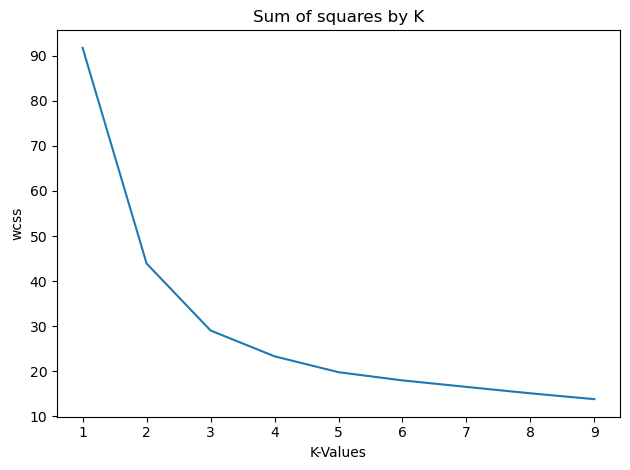

In [28]:
plt.plot(k_values,wcss)
plt.xlabel("K-Values")
plt.ylabel("wcss")
plt.title("Sum of squares by K")
plt.tight_layout()
plt.show()

#### we just go with k=3

Based upon the shape of the above plot - there does appear to be an elbow at k = 3. Prior to that we see a significant drop in the WCSS score, but following the decreases are much smaller, meaning this could be a point that suggests adding more clusters will provide little extra benefit in terms of separating our data. A small number of clusters can be beneficial when considering how easy it is for the business to focus on, and understand, each - so we will continue on, and fit our k-means clustering solution with k = 3.

## Model Fitting

In [66]:
# Instantiate & fit the model

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

## Cluster Sizes
In the below code we firstly assess the number of customers that fall into each cluster.

In [67]:
data_for_clustering["cluster"] = kmeans.labels_

print(data_for_clustering["cluster"].value_counts())


0    641
2    127
1    103
Name: cluster, dtype: int64


Here below it looks like a we got a volume skewed towards 0 and cluster 1 & 2 being smaller and this is'nt right or 
wrong.

This means there are some distinct types of customers in our base that show quite different behaviours and this is actually what we want the "Clustering" to show up

To understand what these clusters do mean, we need to run a bit of profiling on them. This means we just need to look at the summary stats for each based on the variables we used to cluster them. This means we get a bit of view on why these algorithm considered them to be distinct 

So here i am going to do is for each cluster calculate mean percentage of sales for each of product area and just see what shows up

In [69]:
cluster_summary = data_for_clustering.groupby("cluster")[["Dairy","Fruit","Meat","Vegetables"]].mean().reset_index()
cluster_summary

,cluster,Dairy,Fruit,Meat,Vegetables
0,0,0.220875,0.264605,0.376508,0.138011
1,1,0.002382,0.637796,0.003696,0.356126
2,2,0.363948,0.394152,0.029210,0.212690



For Cluster 0 we see a reasonably significant portion of spend being allocated to each of the product areas. For Cluster 1 we see quite high proportions of spend being allocated to Fruit & Vegetables, but very little to the Dairy & Meat product areas. It could be hypothesised that these customers are following a vegan diet. Finally customers in Cluster 2 spend, on average, significant portions within Dairy, Fruit & Vegetables, but very little in the Meat product area - so similarly, we would make an early hypothesis that these customers are more along the lines of those following a vegetarian diet - very interesting!

-----

Even those this is a simple solution, based upon high level product areas it will help leaders in the business, and category managers gain a clearer understanding of the customer base.

Tracking these clusters over time would allow the client to more quickly react to dietary trends, and adjust their messaging and inventory accordingly.

Based upon these clusters, the client will be able to target customers more accurately - promoting products & discounts to customers that are truly relevant to them - overall enabling a more customer focused communication strategy.